In [ ]:
# Generation of new cat images with GANs (Generative Adversarial Networks)

In [2]:
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate
from keras.models import Sequential
from keras.layers import BatchNormalization
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from numpy.random import rand
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os

In [5]:
path = '/content/drive/MyDrive/cat-images/cats.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [6]:
cat_path = '/content/cats'

In [7]:
cat_images = os.listdir(cat_path)

In [8]:
type(cat_images)

list

In [9]:
len(cat_images)

4001

In [10]:
cat = []
for image in cat_images:
  if 'jpg' in image:
    
    path = os.path.join(cat_path, image)
    cat_image = load_img(path)
    cat_image = np.asarray(cat_image)
    cat_image = cat_image.astype('float32')
# Resizing the cat images to (64, 64)
    cat_image = cv2.resize(cat_image, (64,64))
    cat.append(cat_image)

In [11]:
type(cat)

list

In [12]:
len(cat)

4000

In [13]:
cat_array = np.asarray(cat)

In [14]:
cat_array.shape

(4000, 64, 64, 3)

In [15]:
cat_array.dtype

dtype('float32')

In [16]:
X_train = cat_array

In [17]:
X_train.dtype

dtype('float32')

In [18]:
X_train.shape

(4000, 64, 64, 3)

In [19]:
X_train.max()

255.0

In [20]:
# scale from [0,255] to [-1,1]
X_train = (X_train - 127.5) / 127.5

In [21]:
X_train.min(), X_train.max()

(-1.0, 1.0)

In [22]:
# Generator model
def define_generator(latent_dim):
  model = Sequential()
  n_nodes = 512 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 512)))
	# upsample to 8x8
  model.add(Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
 	# upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
 	# upsample to 64x64
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
	# generate
  model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
  return model

In [23]:
# Discriminator model
def define_discriminator(in_shape=(64,64,3)):
	model = Sequential()
	# downsample
	model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 	# downsample
	model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
 	# downsample
	model.add(Conv2D(512, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [24]:
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add the generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [25]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [26]:
# Generating fake samples
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [27]:
# Selecting real samples randomly
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y

In [28]:
# Training
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=16):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	for i in range(n_epochs):
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('Epoch: %d, Batch: %d, d-loss1=%.3f, d-loss2=%.3f g-loss=%.3f' %
				(i+1, j+1, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

In [29]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = X_train
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
Epoch: 81, Batch: 2, d-loss1=0.297, d-loss2=0.196 g-loss=2.526
Epoch: 81, Batch: 3, d-loss1=0.171, d-loss2=0.283 g-loss=2.236
Epoch: 81, Batch: 4, d-loss1=0.349, d-loss2=0.129 g-loss=2.129
Epoch: 81, Batch: 5, d-loss1=0.292, d-loss2=0.199 g-loss=2.192
Epoch: 81, Batch: 6, d-loss1=0.152, d-loss2=0.245 g-loss=1.220
Epoch: 81, Batch: 7, d-loss1=0.104, d-loss2=0.447 g-loss=1.977
Epoch: 81, Batch: 8, d-loss1=0.230, d-loss2=0.355 g-loss=2.719
Epoch: 81, Batch: 9, d-loss1=0.175, d-loss2=0.157 g-loss=1.710
Epoch: 81, Batch: 10, d-loss1=0.276, d-loss2=1.422 g-loss=3.241
Epoch: 81, Batch: 11, d-loss1=0.509, d-loss2=0.253 g-loss=2.894
Epoch: 81, Batch: 12, d-loss1=0.743, d-loss2=0.160 g-loss=2.753
Epoch: 81, Batch: 13, d-loss1=0.548, d-loss2=0.382 g-loss=2.006
Epoch: 81, Batch: 14, d-loss1=0.222, d-loss2=0.764 g-loss=2.531
Epoch: 81, Batch: 15, d-loss1=0.544, d-loss2=0.268 g-loss=2.974
Epoch: 81, Batch: 16, d-loss1=0.384, d-loss2=0.314 g-loss=1.8

In [30]:
# create and save a plot of generated images
def show_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :])
	plt.show()

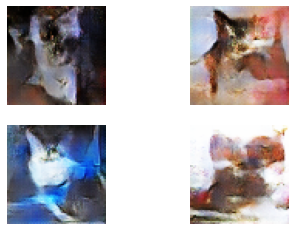

In [34]:
# load model
from keras.models import load_model
model = load_model('generator.h5')
# generate images
latent_points = generate_latent_points(100, 4)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
show_plot(X, 2)